# Importance Sampling

The $J/\Psi \rightarrow \gamma \pi^0 \pi^0$ decay is used here (which has a
narrow $\omega$ state)

Let's go!

## Step 1: Define intensity

First we create the intensity. If this step looks unfamiliar to you, you
might want to check other intensity construction examples using the expert
system.

In [1]:
from pycompwa.expertsystem.ui.system_control import (
    StateTransitionManager, InteractionTypes)
from pycompwa.expertsystem.amplitude.helicitydecay import (
    HelicityAmplitudeGeneratorXML)
from pycompwa.expertsystem.topology.graph import (
    get_intermediate_state_edges)
from pycompwa.expertsystem.state.particle import (
    particle_list)

initial_state = [("J/psi", [-1, 1])]
final_state = [("gamma", [-1, 1]), ("pi0", [0]), ("pi0", [0])]

tbd_manager = StateTransitionManager(initial_state, final_state,
                                     formalism_type='helicity',
                                     topology_building='isobar')

# The omega is so narrow that the hit&miss generation takes way too long.
# Therefore we increase the width artificially in this example!
omega = particle_list["omega(782)"]
parameters = omega['DecayInfo']['Parameter']
for par in parameters:
    if par['@Type'] == 'Width':
        par['Value'] = 0.001

tbd_manager.set_allowed_interaction_types(
    [InteractionTypes.Strong, InteractionTypes.EM])
tbd_manager.allowed_intermediate_particles = ['f2(1270)', 'omega']
graph_interaction_settings_groups = tbd_manager.prepare_graphs()
solutions, violated_rules = tbd_manager.find_solutions(
    graph_interaction_settings_groups)

print("found " + str(len(solutions)) + " solutions!")

xml_generator = HelicityAmplitudeGeneratorXML()
xml_generator.generate(solutions)
xml_generator.write_to_file('model.xml')

found 28 solutions!


## Step 2: Create intensity and generate importance weighted phase space sample

In [2]:
# pycompwa is the python interface to ComPWA's c++ modules
import pycompwa.ui as pwa

particles = pwa.read_particles('model.xml')

kin = pwa.create_helicity_kinematics('model.xml', particles)

# generate phase space sample (flat) used for amplitude normalization
gen = \
    pwa.EvtGenGenerator(kin.get_particle_state_transition_kinematics_info())

rand_gen = pwa.StdUniformRealGenerator(12345)

phsp_sample = pwa.generate_phsp(100000, gen, rand_gen)

# create intensity
builder = pwa.IntensityBuilderXML('model.xml', particles, kin, phsp_sample)
intensity = builder.create_intensity()

# generate importance sampled phase space sample
phsp_sample_importance = pwa.generate_importance_sampled_phsp(
    2000, kin, gen, intensity, rand_gen)

2020-04-09 15:32:41,181 [INFO] HelicityKinematics::HelicityKinematics() | Initialized kinematics for reaction ( J/psi )->( gamma[ID=2] pi0[ID=3] pi0[ID=4] )
Event position to final state ID mapping:
0: 2
1: 3
2: 4



2020-04-09 15:32:41,183 [INFO] Generating phase-space MC: [100000 events] 


2020-04-09 15:32:41,266 [INFO] Setting phase space sample weights...


2020-04-09 15:32:41,268 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_1+pi0_0; already exists!


2020-04-09 15:32:41,269 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_1+pi0_0; already exists!


2020-04-09 15:32:41,271 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_-1+pi0_0; already exists!


2020-04-09 15:32:41,272 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_-1+pi0_0; already exists!


2020-04-09 15:32:41,273 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_-1+pi0_0; already exists!


2020-04-09 15:32:41,274 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_-1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_-1+pi0_0; already exists!


2020-04-09 15:32:41,275 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_1+pi0_0;omega(782)_1_to_gamma_1+pi0_0; already exists!


2020-04-09 15:32:41,275 [ERROR] IntensityBuilderXML::addFunctionTreeComponent(): FunctionTree with name J/psi_1_to_omega(782)_-1+pi0_0;omega(782)_-1_to_gamma_1+pi0_0; already exists!


2020-04-09 15:32:41,279 [INFO] Updating data container content...


2020-04-09 15:32:43,385 [INFO] Generating phase space sample (hit-and-miss importance sampled): [2000 events] 


2020-04-09 15:32:43,884 [INFO] Tools::generateImportanceSampledPhsp() | Error in HitMiss procedure: Maximum value of random number generation smaller then amplitude maximum! We raise the maximum to 46.4232 value and restart generation!


2020-04-09 15:32:44,130 [INFO] Tools::generateImportanceSampledPhsp() | Error in HitMiss procedure: Maximum value of random number generation smaller then amplitude maximum! We raise the maximum to 51.6626 value and restart generation!


2020-04-09 15:32:44,620 [INFO] Tools::generateImportanceSampledPhsp() | Error in HitMiss procedure: Maximum value of random number generation smaller then amplitude maximum! We raise the maximum to 69.7599 value and restart generation!


## Step 3: Visualize the phase space sample

This phase space sample can be visualized in a Dalitz plot. There one expects
more events, where the intensity is large, but still an overall uniform
distribution. First create all subsystems. Since in this example, we have
both $f$ and $\omega$ resonances, all subsystems already exist and this step
is redundant.

In [3]:
kin.create_all_subsystems()
data_set = kin.convert(phsp_sample_importance)

2020-04-09 15:32:48,216 [INFO] creating all Subsystems!


Then we can use `pandas` and `matplotlib` to create a Dalitz plot:

Text(0, 0.5, 'mSq_(pi0,pi0)')

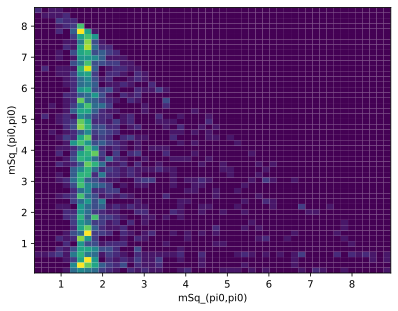

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

id_to_name = kin.get_particle_state_transition_kinematics_info(
).get_final_state_id_to_name_mapping()
mass_x = 'mSq_(3,4)'
mass_y = 'mSq_(2,4)'
plt.hist2d(
    data_set.data[mass_x],
    data_set.data[mass_y],
    bins=50,
)
for id, name in id_to_name.items():
    mass_x = mass_x.replace(str(id), name)
    mass_y = mass_x.replace(str(id), name)
plt.xlabel(mass_x)
plt.ylabel(mass_y)